In [6]:
import pandas as pd

# Load the data from the Excel file
file_path = "./weekly_RSI_backtest_result.xlsx"
data = pd.read_excel(file_path)

# Display the first few rows to understand the structure
data.head()

,Datetime,OPEN,HIGH,LOW,CLOSE,VOLUME,ema_short,ema_long,MACD_line,Signal_line,Histogram,rsi,volume_change,signal,positions
0,2024-04-01 09:15:00,173.00,174.10,173.00,173.80,1450870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1,2024-04-01 09:20:00,173.75,173.95,173.30,173.50,750502,NaN,NaN,NaN,NaN,NaN,NaN,-700368.0,0,0.0
2,2024-04-01 09:25:00,173.60,173.90,173.25,173.60,666539,NaN,NaN,NaN,NaN,NaN,NaN,-83963.0,0,0.0
3,2024-04-01 09:30:00,173.55,173.90,173.45,173.70,372146,NaN,NaN,NaN,NaN,NaN,NaN,-294393.0,0,0.0
4,2024-04-01 09:35:00,173.75,173.85,173.40,173.65,419924,NaN,NaN,NaN,NaN,NaN,NaN,47778.0,0,0.0


In [13]:
import numpy as np

# Ensure the data is sorted by datetime
data["Datetime"] = pd.to_datetime(data["Datetime"])
data = data.sort_values(by="Datetime")

# Calculate EMAs
ema_short_period = 9
ema_long_period = 15
data["ema_short"] = data["CLOSE"].ewm(span=ema_short_period, adjust=False).mean()
data["ema_long"] = data["CLOSE"].ewm(span=ema_long_period, adjust=False).mean()


# Calculate RSI
def calculate_rsi(data, window):
    delta = data["CLOSE"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))


rsi_period = 14
data["rsi"] = calculate_rsi(data, rsi_period)

# Calculate MACD
ema_12 = data["CLOSE"].ewm(span=12, adjust=False).mean()
ema_26 = data["CLOSE"].ewm(span=26, adjust=False).mean()
data["MACD_line"] = ema_12 - ema_26
data["Signal_line"] = data["MACD_line"].ewm(span=9, adjust=False).mean()

# Define the RSI threshold
rsi_threshold = 50

# Initialize the signal column
data["signal"] = 0.0

data.loc[ema_long_period:, "signal"] = np.where(
    (data["ema_short"][ema_long_period:] > data["ema_long"][ema_long_period:])
    & (data["rsi"][ema_long_period:] > rsi_threshold)
    & (data["MACD_line"][ema_long_period:] > data["Signal_line"][ema_long_period:])
    & (
        data["CLOSE"][ema_long_period:]
        > data["CLOSE"].rolling(window=20).mean()[ema_long_period:]
    ),
    1.0,
    0.0,
)
# Display the first few rows to verify the signal generation
data.head()

,Datetime,OPEN,HIGH,LOW,CLOSE,VOLUME,ema_short,ema_long,MACD_line,Signal_line,Histogram,rsi,volume_change,signal,positions
0,2024-04-01 09:15:00,173.00,174.10,173.00,173.80,1450870,173.80000,173.800000,0.000000,0.000000,NaN,NaN,NaN,0.0,NaN
1,2024-04-01 09:20:00,173.75,173.95,173.30,173.50,750502,173.74000,173.762500,-0.023932,-0.004786,NaN,NaN,-700368.0,0.0,0.0
2,2024-04-01 09:25:00,173.60,173.90,173.25,173.60,666539,173.71200,173.742188,-0.034432,-0.010715,NaN,NaN,-83963.0,0.0,0.0
3,2024-04-01 09:30:00,173.55,173.90,173.45,173.70,372146,173.70960,173.736914,-0.034288,-0.015430,NaN,NaN,-294393.0,0.0,0.0
4,2024-04-01 09:35:00,173.75,173.85,173.40,173.65,419924,173.69768,173.726050,-0.037774,-0.019899,NaN,NaN,47778.0,0.0,0.0


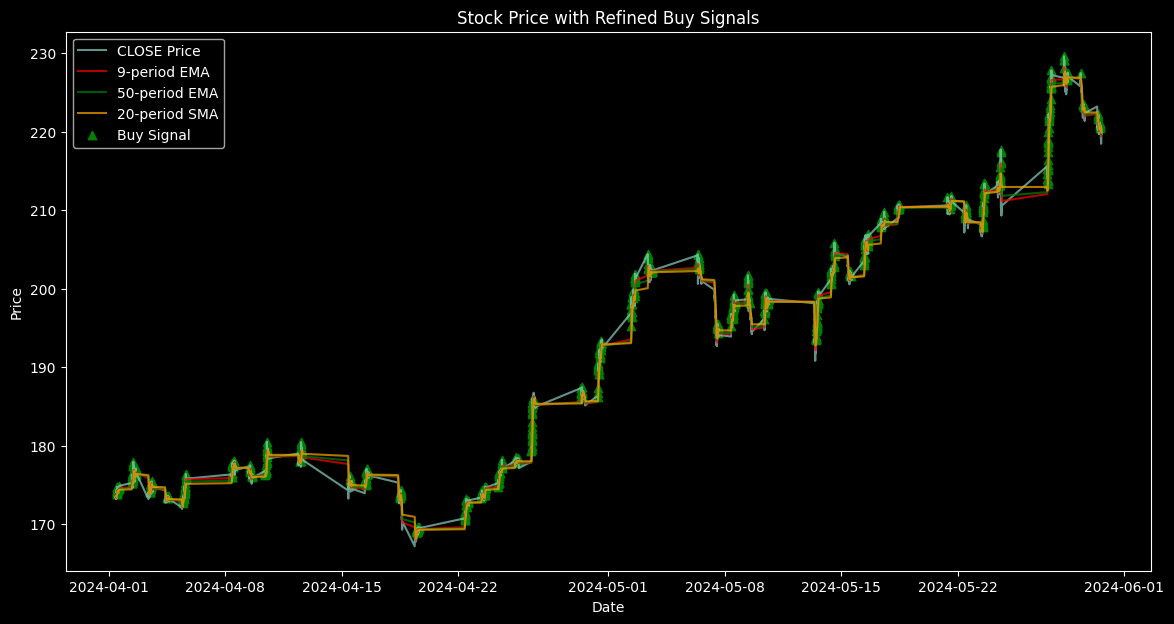

In [14]:
import matplotlib.pyplot as plt

# Plot the closing price and indicators
plt.figure(figsize=(14, 7))
plt.plot(data["Datetime"], data["CLOSE"], label="CLOSE Price", alpha=0.7)
plt.plot(
    data["Datetime"], data["ema_short"], label="9-period EMA", color="r", alpha=0.7
)
plt.plot(
    data["Datetime"], data["ema_long"], label="50-period EMA", color="g", alpha=0.7
)
plt.plot(
    data["Datetime"],
    data["CLOSE"].rolling(window=20).mean(),
    label="20-period SMA",
    color="orange",
    alpha=0.7,
)

# Plot buy signals
buy_signals = data[data["signal"] == 1]
plt.scatter(
    buy_signals["Datetime"],
    buy_signals["CLOSE"],
    marker="^",
    color="g",
    label="Buy Signal",
    alpha=1,
)

plt.title("Stock Price with Refined Buy Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()